<a href="https://colab.research.google.com/github/srivishnu2805/Quantum_Computing-Capstone/blob/main/Review-2/QuantumProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Quantum ML model to predict Customer Churn Predection

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Telco-Customer-Churn.csv to Telco-Customer-Churn.csv


1. Install & Import

In [ ]:
# Install required libraries quietly
!pip install -q pennylane scikit-learn xgboost matplotlib seaborn pandas

# Import core libraries
import numpy as np, pandas as pd, random

# Quantum machine learning library
import pennylane as qml
from pennylane import numpy as pnp

# Preprocessing and ML utilities
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt, seaborn as sns

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

2. Dataset Loading & Preprocessing

In [ ]:
df = pd.read_csv("Telco-Customer-Churn.csv")

if 'customerID' in df.columns: df.drop(columns=['customerID'], inplace=True)
if 'TotalCharges' in df.columns: df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df = df.fillna(df.median(numeric_only=True))
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].fillna(df[c].mode().iloc[0])

y = LabelEncoder().fit_transform(df['Churn'])
X_raw = df.drop(columns=['Churn'])

3. Feature Engineering & PCA

In [ ]:
# One-hot encode categorical variables (drop first to avoid dummy trap)
X = pd.get_dummies(X_raw, drop_first=True)

# Feature engineering: ratio of tenure to monthly charges
if 'tenure' in X.columns and 'MonthlyCharges' in X.columns:
    X['tenure_monthly_ratio'] = X['tenure'] / (X['MonthlyCharges'] + 1e-6)

# Train-test split (stratified to preserve churn balance)
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# Standardize features
scaler = StandardScaler().fit(X_train_df)
X_train_scaled, X_test_scaled = scaler.transform(X_train_df), scaler.transform(X_test_df)

# Reduce dimensions for quantum circuit (PCA → n_qubits)
n_qubits = 4
pca = PCA(n_components=n_qubits, random_state=SEED).fit(X_train_scaled)
X_train_pca, X_test_pca = pca.transform(X_train_scaled), pca.transform(X_test_scaled)

# Map PCA features to angles in range [-π, π] for quantum encoding
min_vals, max_vals = X_train_pca.min(0), X_train_pca.max(0)
to_angles = lambda Xp: ((Xp - min_vals) / (max_vals - min_vals + 1e-9)) * 2 * np.pi - np.pi
X_train_angles, X_test_angles = to_angles(X_train_pca), to_angles(X_test_pca)

In [ ]:
# --- Validation: dataset shapes at each stage ---
print("Original data shape:", df.shape)
print("After preprocessing (with dummies):", X.shape)
print("Train shape:", X_train_df.shape, "Test shape:", X_test_df.shape)
print("After PCA (n_qubits=4):", X_train_pca.shape, X_test_pca.shape)

Original data shape: (7043, 20)
After preprocessing (with dummies): (7043, 31)
Train shape: (5634, 31) Test shape: (1409, 31)
After PCA (n_qubits=4): (5634, 4) (1409, 4)


4. Classical Baselines

In [ ]:
# Function to train a model and compute evaluation metrics
def evaluate(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)                             # Train model
    probs = model.predict_proba(X_te)[:, 1]           # Predicted probabilities
    preds = (probs >= 0.5).astype(int)                # Convert to class labels (0/1)

    # Return performance metrics
    return {
        'model': model,
        'accuracy': accuracy_score(y_te, preds),
        'precision': precision_score(y_te, preds, zero_division=0),
        'recall': recall_score(y_te, preds, zero_division=0),
        'roc_auc': roc_auc_score(y_te, probs)
    }

# Evaluate classical ML models on PCA-reduced features
cls_results = {
    "Logistic": evaluate(LogisticRegression(max_iter=1000), X_train_pca, y_train, X_test_pca, y_test),
    "RandomForest": evaluate(RandomForestClassifier(n_estimators=100), X_train_pca, y_train, X_test_pca, y_test),
    "XGBoost": evaluate(xgb.XGBClassifier(eval_metric='logloss'), X_train_pca, y_train, X_test_pca, y_test)
}

# Print results (rounded for readability, exclude model object)
print("Classical:", {
    k: {m: round(v[m], 4) for m in v if m != 'model'}
    for k, v in cls_results.items()
})

Classical: {'Logistic': {'accuracy': 0.7892, 'precision': 0.6288, 'recall': 0.5027, 'roc_auc': np.float64(0.8262)}, 'RandomForest': {'accuracy': 0.7693, 'precision': 0.5783, 'recall': 0.484, 'roc_auc': np.float64(0.7882)}, 'XGBoost': {'accuracy': 0.7608, 'precision': 0.5591, 'recall': 0.4679, 'roc_auc': np.float64(0.7989)}}


5. Variational Quantum Classifier

In [ ]:
# Quantum device with given number of qubits
dev = qml.device("lightning.qubit", wires=n_qubits)

# Variational layer: RX, RY, RZ rotations + CZ entanglement
def variational_layer(params):
    for i in range(n_qubits):
        qml.RX(params[i,0], wires=i)
        qml.RY(params[i,1], wires=i)
        qml.RZ(params[i,2], wires=i)
    for i in range(n_qubits-1):
        qml.CZ([i, i+1])
    qml.CZ([n_qubits-1, 0])  # close the loop

# Define VQC circuit with input encoding + variational layers
@qml.qnode(dev, interface="autograd")
def vqc_circuit(x, params):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)        # encode data as rotations
    for l in range(params.shape[0]):
        variational_layer(params[l]) # trainable layers
    return qml.expval(qml.PauliZ(0)) # measure expectation

# Prediction probabilities from VQC
def vqc_probs(params, X):
    return pnp.array([(1 - vqc_circuit(x, params)) / 2 for x in X])

# Binary cross-entropy loss
def bce_loss(params, X, Y):
    preds = pnp.clip(vqc_probs(params, X), 1e-6, 1-1e-6)
    return -pnp.mean(Y*pnp.log(preds) + (1-Y)*pnp.log(1-preds))

# Subsample training/testing data (for speed)
X_sub, _, y_sub, _ = train_test_split(X_train_angles, y_train,
                                      train_size=200, random_state=SEED, stratify=y_train)
X_tr_q, y_tr_q = pnp.array(X_sub), pnp.array(y_sub, float)
X_te_q, y_te_q = pnp.array(X_test_angles[:50]), pnp.array(y_test[:50], float)

# Initialize parameters (1 layer, each qubit has 3 rotation angles)
n_layers, param_shape = 1, (1, n_qubits, 3)
params = pnp.array(0.01*np.random.randn(*param_shape), requires_grad=True)

# Optimizer setup
opt = qml.AdamOptimizer(0.2)

# Training loop (5 epochs, mini-batch size = 16)
for e in range(5):
    idx = np.random.permutation(len(X_tr_q))
    for i in range(0, len(idx), 16):
        b = idx[i:i+16]
        params = opt.step(lambda v: bce_loss(v, X_tr_q[b], y_tr_q[b]), params)
    print(f"Epoch {e+1}, loss={bce_loss(params, X_tr_q, y_tr_q):.4f}")

# Evaluate VQC on test set
y_prob_vqc = np.array(vqc_probs(params, X_te_q))
y_pred_vqc = (y_prob_vqc >= 0.5).astype(int)

vqc_metrics = {
    'accuracy': accuracy_score(y_test[:50], y_pred_vqc),
    'precision': precision_score(y_test[:50], y_pred_vqc, zero_division=0),
    'recall': recall_score(y_test[:50], y_pred_vqc, zero_division=0),
    'roc_auc': roc_auc_score(y_test[:50], y_prob_vqc)
}
print("Light VQC:", vqc_metrics)

Epoch 1, loss=0.7282
Epoch 2, loss=0.6256
Epoch 3, loss=0.5723
Epoch 4, loss=0.5738
Epoch 5, loss=0.5686
Light VQC: {'accuracy': 0.7, 'precision': 0.38461538461538464, 'recall': 0.4166666666666667, 'roc_auc': np.float64(0.6885964912280702)}


6. Quantum Kernel SVM

In [ ]:
# Subsample training/testing data for QSVM
X_tr_sub, _, y_tr_sub, _ = train_test_split(
    X_train_angles, y_train, train_size=100, random_state=SEED, stratify=y_train
)
X_te_sub, _, y_te_sub, _ = train_test_split(
    X_test_angles, y_test, train_size=50, random_state=SEED, stratify=y_test
)

# Quantum device for kernel method
dev_k = qml.device("lightning.qubit", wires=n_qubits)

# Quantum kernel circuit: overlap between two embedded states
@qml.qnode(dev_k)
def kernel_circuit(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

# Kernel function: probability of returning to |0...0>
kernel_fn = lambda a, b: kernel_circuit(a, b)[0]

# Build kernel matrices
K_train = np.array(qml.kernels.kernel_matrix(X_tr_sub, X_tr_sub, kernel_fn))
K_test  = np.array(qml.kernels.kernel_matrix(X_te_sub, X_tr_sub, kernel_fn))

# Train QSVM using precomputed kernel
svc = SVC(kernel='precomputed').fit(K_train, y_tr_sub)

# Predictions and evaluation
preds = svc.predict(K_test)
scores = svc.decision_function(K_test)

qsvm_metrics = {
    'accuracy':  accuracy_score(y_te_sub, preds),
    'precision': precision_score(y_te_sub, preds, zero_division=0),
    'recall':    recall_score(y_te_sub, preds, zero_division=0),
    'roc_auc':   roc_auc_score(y_te_sub, scores)
}
print("Light QSVM:", qsvm_metrics)

Light QSVM: {'accuracy': 0.8, 'precision': 0.6, 'recall': 0.6923076923076923, 'roc_auc': np.float64(0.8523908523908523)}


7. Results & Comparison

,accuracy,precision,recall,roc_auc
Logistic,0.7892,0.6288,0.5027,0.8262
RandomForest,0.7693,0.5783,0.4840,0.7882
XGBoost,0.7608,0.5591,0.4679,0.7989
VQC,0.7000,0.3846,0.4167,0.6886
QSVM,0.8000,0.6000,0.6923,0.8524


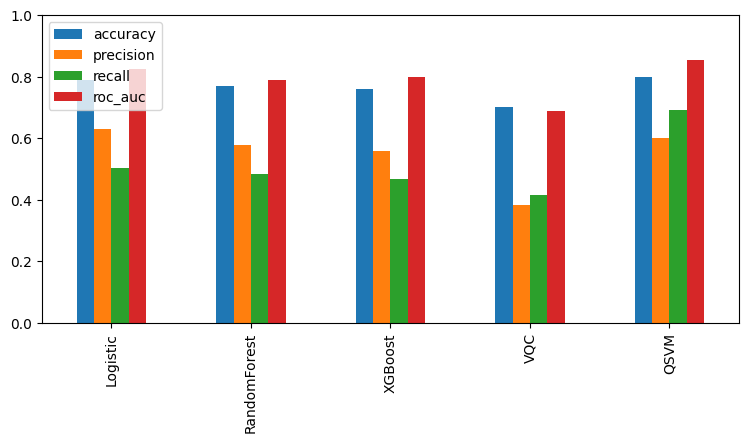

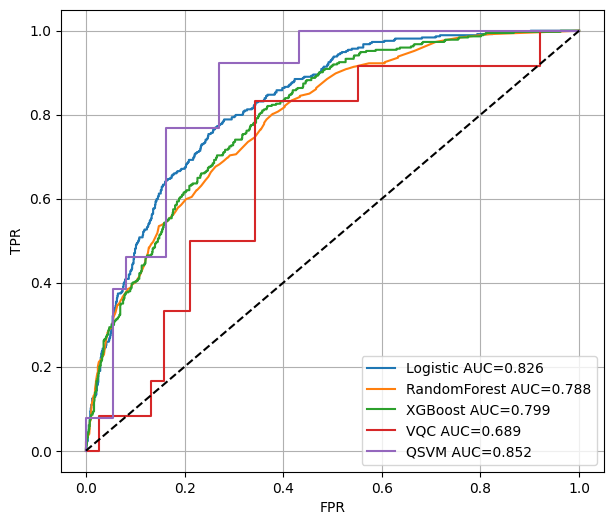

In [ ]:
# Collect all metrics into a single dictionary
all_metrics = {
    'Logistic':     {k: cls_results['Logistic'][k] for k in ['accuracy','precision','recall','roc_auc']},
    'RandomForest': {k: cls_results['RandomForest'][k] for k in ['accuracy','precision','recall','roc_auc']},
    'XGBoost':      {k: cls_results['XGBoost'][k] for k in ['accuracy','precision','recall','roc_auc']},
    'VQC':          vqc_metrics,
    'QSVM':         qsvm_metrics
}

# Convert to DataFrame for easy comparison
dfm = pd.DataFrame(all_metrics).T
display(dfm.style.format("{:.4f}"))   # nice formatted output

# Bar chart comparison of metrics
dfm.plot(kind='bar', figsize=(9,4))
plt.ylim(0,1)
plt.show()

# ROC curve comparison: Classical vs Quantum
plt.figure(figsize=(7,6))

# Classical models
for name in ['Logistic','RandomForest','XGBoost']:
    probs = cls_results[name]['model'].predict_proba(X_test_pca)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} AUC={roc_auc_score(y_test, probs):.3f}")

# VQC
fpr, tpr, _ = roc_curve(y_test[:50], y_prob_vqc)
plt.plot(fpr, tpr, label=f"VQC AUC={vqc_metrics['roc_auc']:.3f}")

# QSVM
fpr, tpr, _ = roc_curve(y_te_sub, scores)
plt.plot(fpr, tpr, label=f"QSVM AUC={qsvm_metrics['roc_auc']:.3f}")

# Formatting
plt.plot([0,1],[0,1],'k--')   # diagonal baseline
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- Result Analysis Remarks ---
print("\n--- Result Analysis ---")
print("Classical models → higher accuracy and stability (Logistic, RF, XGBoost).")
print("Quantum models → currently lower accuracy, but demonstrate feasibility of VQC & QSVM.")
print("Comparison → Classical > Quantum today, but Quantum offers research novelty and future scalability.")


--- Result Analysis ---
Classical models → higher accuracy and stability (Logistic, RF, XGBoost).
Quantum models → currently lower accuracy, but demonstrate feasibility of VQC & QSVM.
Comparison → Classical > Quantum today, but Quantum offers research novelty and future scalability.



Generating VQC Circuit Diagram...


/tmp/ipython-input-4048906631.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


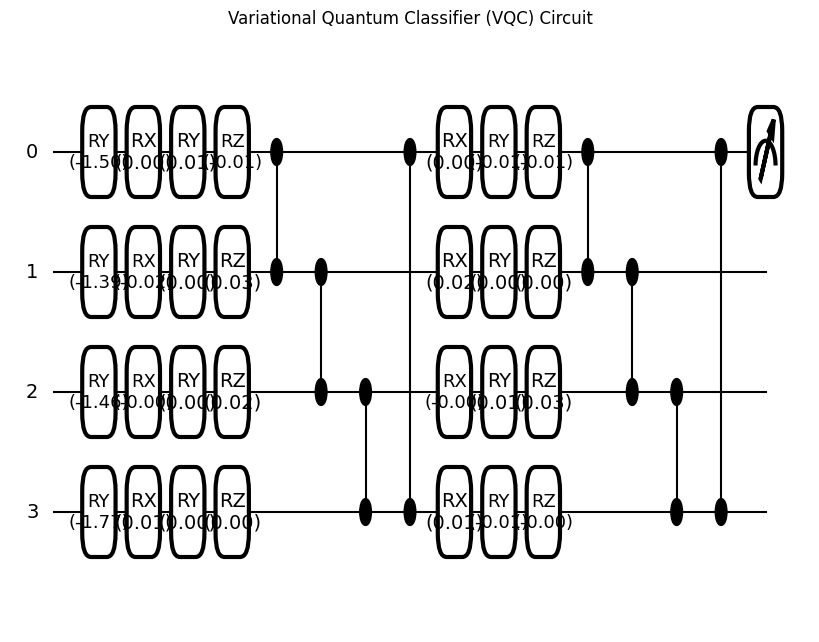


Generating Quantum Kernel Circuit Diagram...


/tmp/ipython-input-4048906631.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


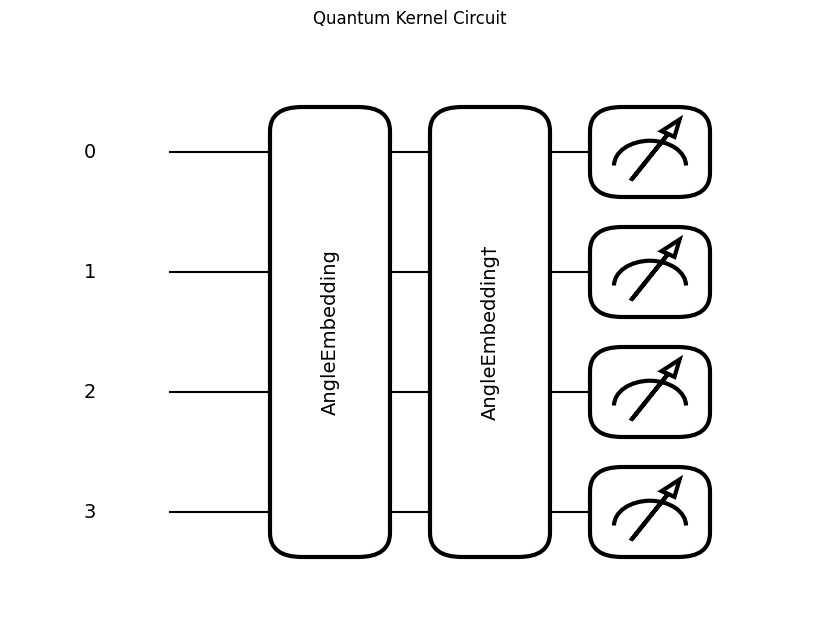

In [ ]:
# --- VQC Circuit Diagram ---
print("\nGenerating VQC Circuit Diagram...")
sample_x = X_train_angles[0]
params_for_drawing = pnp.array(0.01 * np.random.randn(2, n_qubits, 3), requires_grad=False)

fig, ax = qml.draw_mpl(vqc_circuit, decimals=2)(x=sample_x, params=params_for_drawing)
fig.set_size_inches(8, 6)
ax.set_title("Variational Quantum Classifier (VQC) Circuit")
plt.tight_layout()
plt.show()

# --- Quantum Kernel Circuit Diagram ---
print("\nGenerating Quantum Kernel Circuit Diagram...")
sample_x1, sample_x2 = X_tr_sub[0], X_tr_sub[1]

fig, ax = qml.draw_mpl(kernel_circuit, decimals=2)(x1=sample_x1, x2=sample_x2)
fig.set_size_inches(8, 6)
ax.set_title("Quantum Kernel Circuit")
plt.tight_layout()
plt.show()